# Bellman's Grid World

This is the general playground to test the Double Conditional Maximum Entropy Inverse Learning (**DECIMEIL**) Algorithm. The premise is a `10 x 10` grid world with various routes starting from different origins `s` and ending at different destinations `g`. 

Each link $i$ has a routing cost, *intrinsic* to the link itself.
$$ c_\theta (i) = f(\text{distance, wind, sector load, airspace charge, convections, (airline preference, source, goal)}) $$

Other consideration: path-overlapping correction term for the logit $\rightarrow$ will be dealt with later when we gradually expand the expressiveness of the cost function.

The goal of **DECIMEIL** is to:
- Learn a discrete choice model that explains the route choice for each flight.
- Adaptable to large scale learning.
- Expandable to neural network based cost approximations.

# Create the grid world and demonstration routes

In [2]:
%load_ext autoreload
%autoreload 2

import networkx as nx 
from matplotlib import pyplot as plt 
import numpy as np

Created 4950 edges out of 300 possible edges
NOTICE: The nodes are strings, not integers.


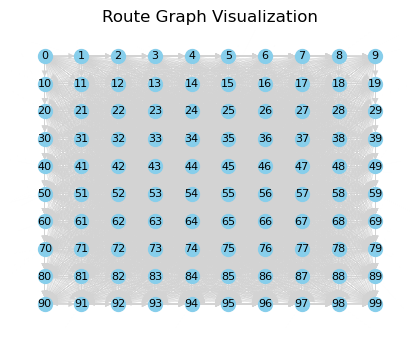

In [3]:
# Create a graph consisting of 100 nodes
# Create a graph with 100 nodes in a 10x10 grid
G = nx.DiGraph()

# Add nodes with attributes
for i in range(100):
    row = i // 10  # Integer division to get row (0-4)
    col = i % 10   # Modulo to get column (0-4)
    G.add_node(str(i), label=i, row=row, col=col, lat=row*0.1, lon=col*0.1)

# Add all possible edges between the 100 nodes (100C2 edges)
for i in range(100):
    for j in range(i+1, 100):  # Start from i+1 to avoid duplicates and self-loops
        # Calculate distance between nodes based on their grid positions
        node_i_row, node_i_col = G.nodes[str(i)]['row'], G.nodes[str(i)]['col']
        node_j_row, node_j_col = G.nodes[str(j)]['row'], G.nodes[str(j)]['col']
        
        # Euclidean distance as edge weight
        distance = np.sqrt((node_i_row - node_j_row)**2 + (node_i_col - node_j_col)**2)
        
        # Add edge with distance as weight
        G.add_edge(str(i), str(j), weight = distance, distance = distance, preference_score = 0.0)

# Print the number of edges to verify
print(f"Created {G.number_of_edges()} edges out of {25*24//2} possible edges")
print(f'NOTICE: The nodes are strings, not integers.')

# Visualize the graph
plt.figure(figsize=(4, 3))

# Get node positions from row and col attributes
pos = {node: (G.nodes[node]['col'], -G.nodes[node]['row']) for node in G.nodes()}

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, font_size=8, edge_color='lightgray', width=0.25)

# Draw edge weights (distances)
# edge_labels = {(i, j): f"{G[i][j]['weight']:.2f}" for i, j in G.edges()}
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Route Graph Visualization")
plt.axis('off')  # Turn off axis
plt.show()

In [4]:
import math
import random

def generate_routes(G, node_ori, node_dest):
    """
    Generate 5 different routes from origin to destination node in the graph.
    
    Args:
        G (networkx.Graph): The graph to search
        node_ori (int): Origin node ID
        node_dest (int): Destination node ID
        
    Returns:
        list: List of 5 different paths, where each path is a list of node IDs
    """
    routes = []
    
    # 1. Shortest path (using Dijkstra's algorithm)
    try:
        shortest_path = nx.shortest_path(G, source=node_ori, target=node_dest, weight='weight')
        routes.append(shortest_path)
    except nx.NetworkXNoPath:
        print(f"No path exists between nodes {node_ori} and {node_dest}")
        return []
    
    # 2. Second shortest path using edge removal technique
    temp_graph = G.copy()
    for i in range(len(shortest_path)-1):
        # Temporarily remove each edge in the shortest path and find alternative
        u, v = shortest_path[i], shortest_path[i+1]
        temp_graph.remove_edge(u, v)
        try:
            alt_path = nx.shortest_path(temp_graph, source=node_ori, target=node_dest, weight='weight')
            if alt_path not in routes:
                routes.append(alt_path)
                break
        except nx.NetworkXNoPath:
            pass
        # Restore the edge for next iteration
        temp_graph.add_edge(u, v, weight=G[u][v]['weight'])
    
    # # 3. Multiple paths with random weights (to encourage diversity)
    # for attempt in range(10):  # Try to generate 3 different paths with random weights
    #     rand_graph = G.copy()
    #     for u, v in rand_graph.edges():
    #         # Add random factor to weights with different randomization each time
    #         rand_factor = 0.3 + random.random() * 1.4  # Wider range for more diversity
    #         rand_graph[u][v]['weight'] = G[u][v]['weight'] * rand_factor
        
    #     try:
    #         rand_path = nx.shortest_path(rand_graph, source=node_ori, target=node_dest, weight='weight')
    #         if rand_path not in routes:
    #             routes.append(rand_path)
    #     except nx.NetworkXNoPath:
    #         continue
    
    # 4. Multiple paths with more nodes (longer but potentially more interesting)
    for attempt in range(10):  # Try different variations of the longer path approach
        long_graph = G.copy()
        for u, v in long_graph.edges():
            # Vary the transformation to get different long paths
            if attempt == 0:
                # Use reciprocal of weight instead of negative log
                long_graph[u][v]['inv_weight'] = 1.0 / (G[u][v]['weight'] + 0.001)  # Add small constant to avoid division by zero
            elif attempt == 1:
                # Reciprocal with random factor
                long_graph[u][v]['inv_weight'] = 1.0 / ((G[u][v]['weight'] * (0.7 + random.random() * 0.6)) + 0.001)
            else:
                # More extreme transformation to prefer even more hops
                long_graph[u][v]['inv_weight'] = 1.0 / ((G[u][v]['weight'] ** 2) + 0.001)
        
        try:
            long_path = nx.shortest_path(long_graph, source=node_ori, target=node_dest, weight='inv_weight')
            if long_path not in routes:
                routes.append(long_path)
        except nx.NetworkXNoPath:
            continue
    
    # 5. A* path with custom heuristic
    def heuristic(u, v):
        # Manhattan distance on the grid
        u_row, u_col = G.nodes[u]['row'], G.nodes[u]['col']
        v_row, v_col = G.nodes[v]['row'], G.nodes[v]['col']
        return abs(u_row - v_row) + abs(u_col - v_col)
    
    a_star_path = nx.astar_path(G, source=node_ori, target=node_dest, 
                                heuristic=heuristic, weight='weight')
    if a_star_path not in routes:
        routes.append(a_star_path)
    
    # If we still need more routes, generate some with random walks
    while len(routes) < 20:
        current = node_ori
        path = [current]
        visited = set([current])
        
        while current != node_dest:
            neighbors = list(G.neighbors(current))
            # Filter out already visited nodes if possible
            unvisited = [n for n in neighbors if n not in visited]
            if not unvisited and not neighbors:
                # Dead end with no way to destination
                break
            if not unvisited:
                # If all neighbors visited, allow revisiting
                unvisited = neighbors
            
            # Choose neighbor that's closer to destination with some randomness
            weights = []
            for n in unvisited:
                # Prefer nodes closer to destination
                n_row, n_col = G.nodes[n]['row'], G.nodes[n]['col']
                dest_row, dest_col = G.nodes[node_dest]['row'], G.nodes[node_dest]['col']
                dist_to_dest = math.sqrt((n_row - dest_row)**2 + (n_col - dest_col)**2)
                # Lower distance gets higher weight
                weights.append(1.0 / (dist_to_dest + 0.1))
            
            # Normalize weights
            total = sum(weights)
            weights = [w/total for w in weights]
            
            next_node = random.choices(unvisited, weights=weights)[0]
            path.append(next_node)
            visited.add(next_node)
            current = next_node
            
            # Prevent infinite loops
            if len(path) > 3 * len(G):
                break
        
        if current == node_dest and path not in routes:
            routes.append(path)
    
    # Ensure we return exactly 10 routes (or fewer if impossible)
    return routes[:20]

In [5]:
def plot_routes(G, routes, node_size=200, route_colors=None, line_width=2, alpha=0.7, probabilities=None):
    """
    Plot multiple routes on the graph, each in its own subplot.
    
    Parameters:
    -----------
    G : networkx.Graph
        The graph containing the nodes and edges
    routes : list of lists
        List of routes, where each route is a list of node IDs
    figsize : tuple, optional
        Figure size (width, height) in inches
    node_size : int, optional
        Size of the nodes in the plot
    route_colors : list, optional
        List of colors for each route. If None, colors will be generated automatically
    line_width : int, optional
        Width of the route lines
    alpha : float, optional
        Transparency of the route lines
    """
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import networkx as nx
    import math
    
    # Calculate grid dimensions
    n_routes = len(routes)
    n_rows, n_cols = 5, 5

    # Automatically determine figure size based on number of routes
    if n_routes <= 4:
        n_rows, n_cols = 2, 2
        figsize = (8, 6)
    elif n_routes <= 9:
        n_rows, n_cols = 3, 3
        figsize = (12, 10)
    elif n_routes <= 16:
        n_rows, n_cols = 4, 4
        figsize = (16, 13)
    else:
        n_rows, n_cols = 5, 5
        figsize = (20, 16)
    
    # Create figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    
    # Get node positions from the graph
    pos = {node: (G.nodes[node]['col'], -G.nodes[node]['row']) for node in G.nodes()}
    
    # Generate colors for routes if not provided
    if route_colors is None:
        # Use a colormap to generate distinct colors
        cmap = plt.cm.rainbow
        route_colors = [cmap(i/n_routes) for i in range(n_routes)]
    
    # Plot each route in its own subplot
    for i, route in enumerate(routes):
        if i >= n_rows * n_cols:
            break  # Don't exceed available subplots
            
        ax = axes[i]
        
        # Draw the graph structure (all nodes and edges)
        nx.draw_networkx_nodes(G, pos, node_color='lightgray', node_size=node_size/2, ax=ax)
        # nx.draw_networkx_edges(G, pos, edge_color='lightgray', width=0.5, alpha=0.5, ax=ax)
        
        # Draw the route edges
        route_edges = [(route[j], route[j+1]) for j in range(len(route)-1)]
        color = route_colors[i % len(route_colors)]
        
        # Draw the route
        nx.draw_networkx_edges(G, pos, edgelist=route_edges, 
                              edge_color=[color], width=line_width, alpha=alpha, ax=ax)
        
        # Highlight start and end nodes
        nx.draw_networkx_nodes(G, pos, nodelist=[route[0]], 
                              node_color='green', node_size=node_size, ax=ax)
        nx.draw_networkx_nodes(G, pos, nodelist=[route[-1]], 
                              node_color='red', node_size=node_size, ax=ax)
        
        # Add node labels for start and end nodes
        labels = {node: str(node) for node in [route[0], route[-1]]}
        nx.draw_networkx_labels(G, pos, labels=labels, ax=ax)
        if probabilities is not None:
            ax.set_title(f"Route {i}: {route[0]} → {route[-1]}\nProb: {probabilities[i]:.2f}")
        else:
            ax.set_title(f"Route {i}: {route[0]} → {route[-1]}")
        ax.axis('off')
    
    # Hide any unused subplots
    for i in range(n_routes, n_rows * n_cols):
        axes[i].axis('off')
    
    plt.suptitle(f"Graph with {n_routes} routes", fontsize=16)
    plt.tight_layout()
    return fig


## Route Cluster 1: 0 → 24

In [6]:
# Set random seed for reproducibility
import random
random.seed(69420)

routes_0_24 = generate_routes(G, '0', '24')


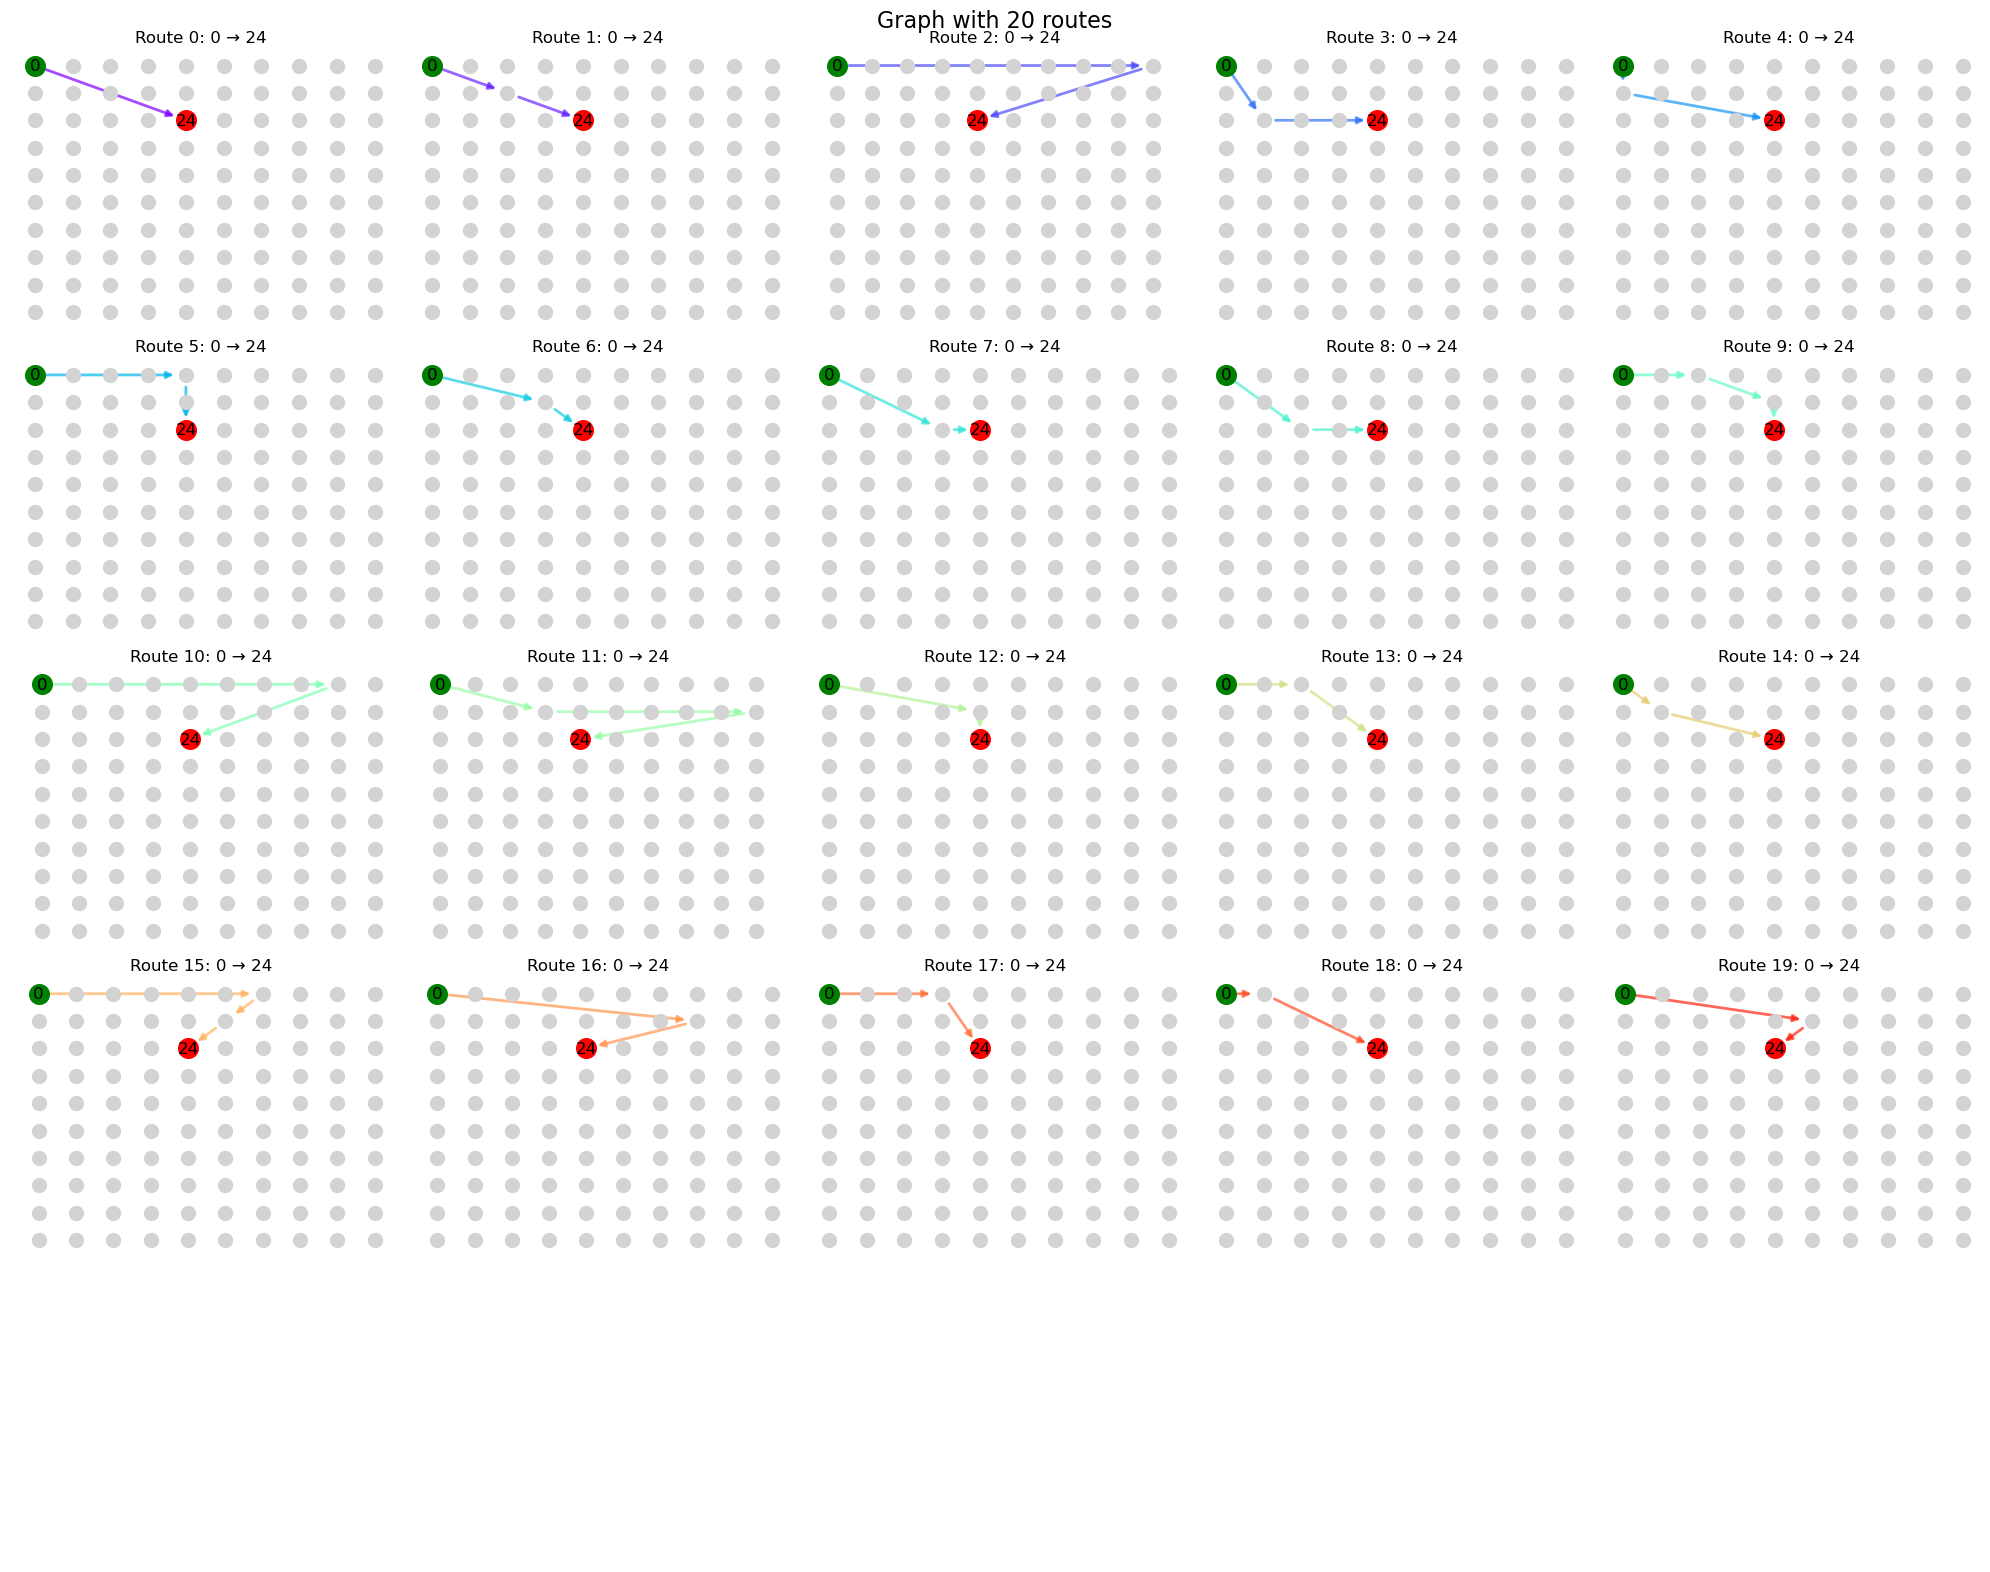

In [7]:
plot_routes(G, routes_0_24)
plt.show()


In [8]:
routes_0_24_final = [routes_0_24[x] for x in [0, 1, 6, 8, 9, 10, 15, 18]]
# Create a random probability distribution for the routes
probabilities = np.random.rand(len(routes_0_24_final))

# Normalize the probabilities to sum to 1
routes_0_24_final_prob = [p / sum(probabilities) for p in probabilities]

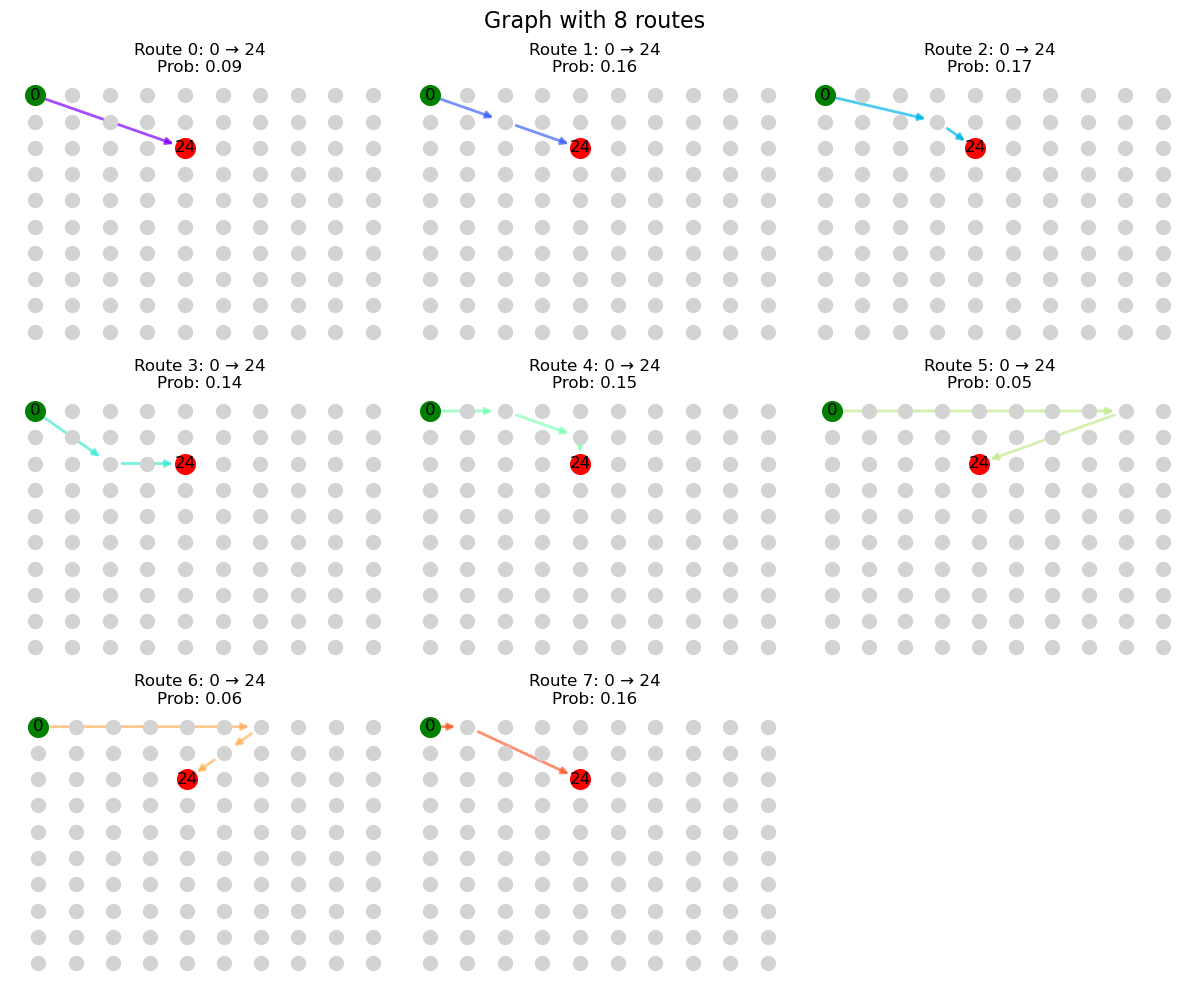

In [9]:
plot_routes(G, routes_0_24_final, probabilities=routes_0_24_final_prob)
plt.show()

# Cost, Adjacency Matrix Computation

In [10]:
from bellman_ford_sparse1100 import compute_edge_costs_dict

costs = compute_edge_costs_dict(G, alpha_pref = 1.0)

In [11]:
from bellman_ford_sparse1100 import graph_to_sparse_matrices
A, C, node_mapping = graph_to_sparse_matrices(G, costs) # note the graph is directional. There are no "going-back" links.
# Check sparsity pattern match
from bellman_ford_sparse1100 import check_sparsity_pattern_match
check_sparsity_pattern_match(A, C)

True

# <font color='green'>Value Iterations</font>

## Forward and Backward Value Functions

In [12]:
from bellman_ford_sparse1100 import bellman_fw, bellman_bw
import time 
start_time = time.time()
V_fw = bellman_fw(A, C, 0, max_iter=1000, tol=1e-6, epsilon=1e-10)
V_fw_time = time.time() - start_time
start_time = time.time()
V_bw = bellman_bw(A, C, 24, max_iter=1000, tol=1e-6, epsilon=1e-10)
V_bw_time = time.time() - start_time
print(f'Forward VI time: {V_fw_time:.4f} seconds')
print(f'Backward VI time: {V_bw_time:.4f} seconds')

Forward VI time: 0.0033 seconds
Backward VI time: 0.0014 seconds


## Bellman Forward Validation

We also compute the value function in a more traditional way in order to verify the vectorization trick we used in the `sparse1100` library.

In [13]:
def bellman_fw_verification(graph: nx.DiGraph, costs: dict, 
                           max_iterations: int = 1000, 
                           tolerance: float = 1e-5) -> dict:
    """
    Computes the value function for all nodes using the logsumexp formula:
    V(i) = -log(∑_{k ∈ pred(i)} exp(-weight_of_edge_k - cost(k, i)))
    
    This is a verification function that computes values in a single pass for each node
    based on its predecessors' values.
    
    Parameters:
    -----------
    graph : nx.DiGraph
        The directed graph representing the route network
    
    costs : dict
        Dictionary mapping edge tuples (u, v) to their costs
    
    max_iterations : int, optional (default=1000)
        Maximum number of iterations to perform
    
    tolerance : float, optional (default=1e-5)
        Convergence tolerance
        
    Returns:
    --------
    dict
        Dictionary mapping nodes to their computed value functions
    """
    from scipy.special import logsumexp
    import numpy as np
    
    # Get all nodes in the graph
    nodes = list(graph.nodes())
    
    # Initialize values to infinity
    V = {node: np.inf for node in nodes}
    
    # Find sources (nodes with no incoming edges)
    sources = [node for node in nodes if len(list(graph.predecessors(node))) == 0]
    
    # Initialize source nodes with value 0
    for source in sources:
        V[source] = 0.0
    
    # If no sources found, pick a node and make it the source
    if not sources and nodes:
        V[nodes[0]] = 0.0
    
    # Iterate until convergence or max iterations
    for iteration in range(max_iterations):
        V_old = V.copy()
        max_delta = 0.0
        
        for node in nodes:
            # Skip source nodes
            if node in sources:
                continue
                
            predecessors = list(graph.predecessors(node))
            if not predecessors:
                continue
                
            # Calculate terms for the logsumexp
            terms = []
            for pred in predecessors:
                edge = (pred, node)
                if edge in costs and np.isfinite(V_old[pred]):
                    # Use the formula V(i) = -log(∑_{k ∈ pred(i)} exp(-weight_of_edge_k - cost(k, i)))
                    terms.append(-costs[edge] - V_old[pred])
            
            # Compute new value with logsumexp
            if not terms:
                new_value = np.inf
            else:
                new_value = -logsumexp(terms)
            
            # Update value and track change
            delta = abs(new_value - V[node])
            max_delta = max(max_delta, delta)
            V[node] = new_value
        
        # Check for convergence
        if max_delta < tolerance:
            # print(f"Bellman-Ford verification converged in {iteration + 1} iterations.")
            return V
    
    # print(f"Warning: Bellman-Ford verification did not converge within {max_iterations} iterations. Max delta: {max_delta}")
    return V

In [14]:
time_start = time.time()
V_fw_test = bellman_fw_verification(G, costs)
time_end = time.time()
print(f'Verification time: {time_end - time_start:.4f} seconds')

Verification time: 0.3576 seconds


In [15]:
V_fw_test_matrix = np.zeros_like(V_fw)
for key, val in V_fw_test.items():
    V_fw_test_matrix[int(key)] = val 

In [16]:
if np.max(np.abs(V_fw - V_fw_test_matrix)) < 1e-3:
    print('\033[92mTwo VI methods arrive at the same result.\nTest passed. ✅\033[0m')
else:
    print('\033[91mTwo VI methods DID NOT arrive at the same result. Something is wrong!\033[0m')

Two VI methods arrive at the same result.
Test passed. ✅


## Bellman Backward Validation

In [17]:
import networkx as nx
from scipy.special import logsumexp
import numpy as np

def bellman_backward_verification(graph: nx.DiGraph, costs: dict, target: any,
                               max_iterations: int = 1000,
                               tolerance: float = 1e-5) -> dict:
    """
    Computes the cost-to-go value function for all nodes using the logsumexp formula:
    V(j) = -log(∑_{i ∈ succ(j)} exp(-cost(j, i) - V(i)))

    This function computes values iteratively starting from the target node
    and propagating backwards.

    Parameters:
    -----------
    graph : nx.DiGraph
        The directed graph representing the transitions. Nodes are keys.
    costs : dict
        Dictionary mapping edge tuples (u, v) to their costs cost(u, v).
    target : any
        The target/goal node, must be a key in the graph nodes.
    max_iterations : int, optional (default=1000)
        Maximum number of iterations to perform.
    tolerance : float, optional (default=1e-5)
        Convergence tolerance.

    Returns:
    --------
    dict
        Dictionary mapping nodes to their computed cost-to-go value functions.
        Nodes that cannot reach the target will have a value of infinity.

    Raises:
    -------
    ValueError
        If the target node is not found in the graph.
    """
    nodes = list(graph.nodes())

    if target not in nodes:
        raise ValueError(f"Target node {target} not found in the graph.")

    # Initialize values to infinity
    V = {node: np.inf for node in nodes}

    # Initialize target node value to 0
    V[target] = 0.0

    # Iterate until convergence or max iterations
    for iteration in range(max_iterations):
        V_old = V.copy()
        max_delta = 0.0

        # Compute new values for all nodes based on V_old
        V_new = {node: np.inf for node in nodes} # Initialize next iteration's values
        V_new[target] = 0.0 # Target value remains 0

        for node in nodes:
            # Skip target node, its value is fixed at 0
            if node == target:
                continue

            successors = list(graph.successors(node))

            # Calculate terms for the logsumexp based on V_old of successors
            terms = []
            for succ in successors:
                edge = (node, succ)
                # Include term if edge exists and successor has finite cost-to-go in V_old
                if edge in costs and np.isfinite(V_old[succ]):
                    # Argument for logsumexp is [-cost(j, i) - V_old(i)]
                    terms.append(-costs[edge] - V_old[succ])

            # Compute new value with logsumexp
            if not terms:
                # If no successors lead to a finite cost path to the target, value remains infinite
                current_new_value = np.inf
            else:
                # V(j) = -log(sum(exp(term_i)))
                current_new_value = -logsumexp(terms)

            V_new[node] = current_new_value

            # Calculate the change compared to the previous iteration's value V_old[node]
            delta = np.inf # Default to infinite change
            if np.isinf(V_old[node]) and np.isinf(current_new_value):
                 delta = 0.0 # No change if both are infinite
            elif not (np.isinf(V_old[node]) or np.isinf(current_new_value)):
                 # Calculate finite change only if both old and new values are finite
                 delta = abs(current_new_value - V_old[node])

            # Track the maximum *finite* change across all nodes for convergence check
            if np.isfinite(delta):
                 max_delta = max(max_delta, delta)

        # Update V for the next iteration
        V = V_new

        # Check for convergence
        if max_delta < tolerance and iteration > 50: # important: we iterate a little longer to ensure convergence
            print(f"Backward Bellman (logsumexp) converged in {iteration + 1} iterations.")
            return V

    # print(f"Warning: Backward Bellman (logsumexp) did not converge within {max_iterations} iterations. Max delta: {max_delta}")
    return V


In [18]:
time_start = time.time()
V_bw_test = bellman_backward_verification(G, costs, '24')
time_end = time.time()
print(f'Verification time: {time_end - time_start:.4f} seconds')

Backward Bellman (logsumexp) converged in 52 iterations.
Verification time: 0.1874 seconds


In [19]:
V_bw_test_matrix = np.zeros_like(V_bw)
for key, val in V_bw_test.items():
    V_bw_test_matrix[int(key)] = val 
if np.max(np.abs(V_bw[np.isfinite(V_bw) & np.isfinite(V_bw_test_matrix)] - V_bw_test_matrix[np.isfinite(V_bw) & np.isfinite(V_bw_test_matrix)])) < 1e-3:
    print('\033[92mTwo VI methods arrive at the same result.\nTest passed. ✅\033[0m')
else:
    print('\033[91mTwo VI methods DID NOT arrive at the same result. Something is wrong!\033[0m')

Two VI methods arrive at the same result.
Test passed. ✅


**<font color="green">All the tests appear to pass: the logsumexp vectorization trick worked marvelously, reducing computational speed by 10x.</font>**

# Double Conditioned Value Function

Value Functions (Lower is Better)


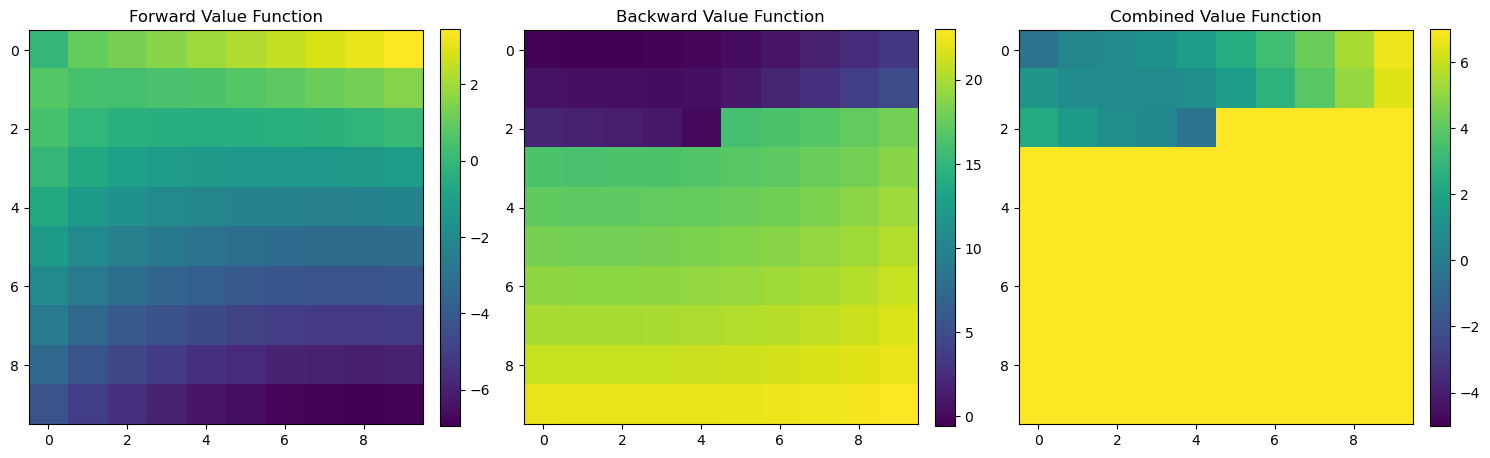

In [20]:
print('Value Functions (Lower is Better)')

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
im1 = plt.imshow(V_fw.reshape(10, 10), cmap='viridis')
plt.title('Forward Value Function')
plt.colorbar(im1, fraction=0.046, pad=0.04)

plt.subplot(1, 3, 2)
im2 = plt.imshow(V_bw.reshape(10, 10), cmap='viridis')
plt.title('Backward Value Function')
plt.colorbar(im2, fraction=0.046, pad=0.04)

plt.subplot(1, 3, 3)
U = V_fw + V_bw
im3 = plt.imshow(U.reshape(10, 10), cmap='viridis', vmin=-5, vmax=7)
plt.title('Combined Value Function')
plt.colorbar(im3, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


Note that $V_{bw}(0) = -0.44$ is quite small (negative or positive is not important), while $V_{bw}(23) = 1.0$ is much larger. Two remarks about the backward value function:

- $V_{bw} \propto c$: the higher the cost is, the higher the value function is.
- $V_{bw} \propto \frac{1}{|\xi_{i\rightarrow g}|}$: the more paths from the node to the goal, the lower the value function is.

In this light, $V_{bw}(23)$ is just the cost of the edge from `23` to `24`, because it is the only connection. On the other hand, node `0` has lots of paths to `24` hence its value is lower.

**<font color='green'>So, this backward value function checks out.</font>**

# Edge Transition Probabilities

In [21]:
from bellman_ford_sparse1100 import compute_expected_traversals, compute_edge_transition_probabilities  
Pe_csr = compute_edge_transition_probabilities(A, C, V_fw, V_bw)
Pe = Pe_csr.toarray()

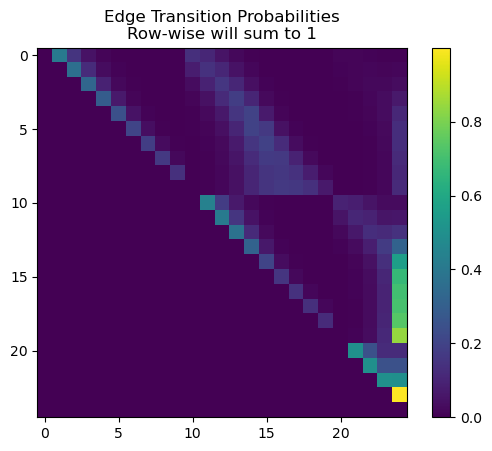

In [22]:
plt.imshow(Pe[0:25, 0:25])
plt.title('Edge Transition Probabilities\nRow-wise will sum to 1')
plt.colorbar()
plt.show()


# Edge Traversals

In [23]:
from bellman_ford_sparse1110 import compute_edge_traversal_likelihoods
edge_traversals = compute_edge_traversal_likelihoods(A, C, V_fw, V_bw, 0)

**NOTICE**: `edge_traversals` is the expected number of traversals, that is:
$$ L(i, j) = P(i, j) = \frac{exp(-V_f(i) - c_{ij} - V_b(j))}{Z} $$
where
$$ Z = -V_b(s) = \sum_{\xi_{s \rightarrow g}} exp(-c(\xi)) $$

But the `edge_transition_probabilities` are $p(i | j)$ such that:
$$ \sum_{j \in succ(i)} p(i | j) = 1 $$
The probability sum holds for *every* source node of a link.

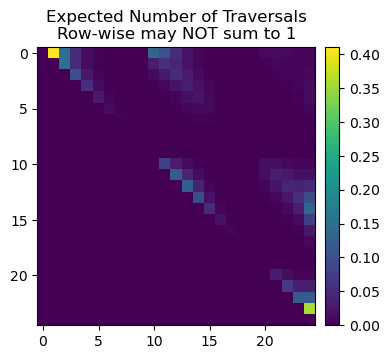

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax2 = plt.subplots(figsize=(4, 4))

# Second subplot (Edge Traversals)
im2 = ax2.imshow(edge_traversals.toarray().reshape((100, 100))[:25, :25])
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im2, cax=cax2)
ax2.set_title('Expected Number of Traversals\nRow-wise may NOT sum to 1')

plt.tight_layout()
plt.show()


There probabilities always sum to 1 for each source node!


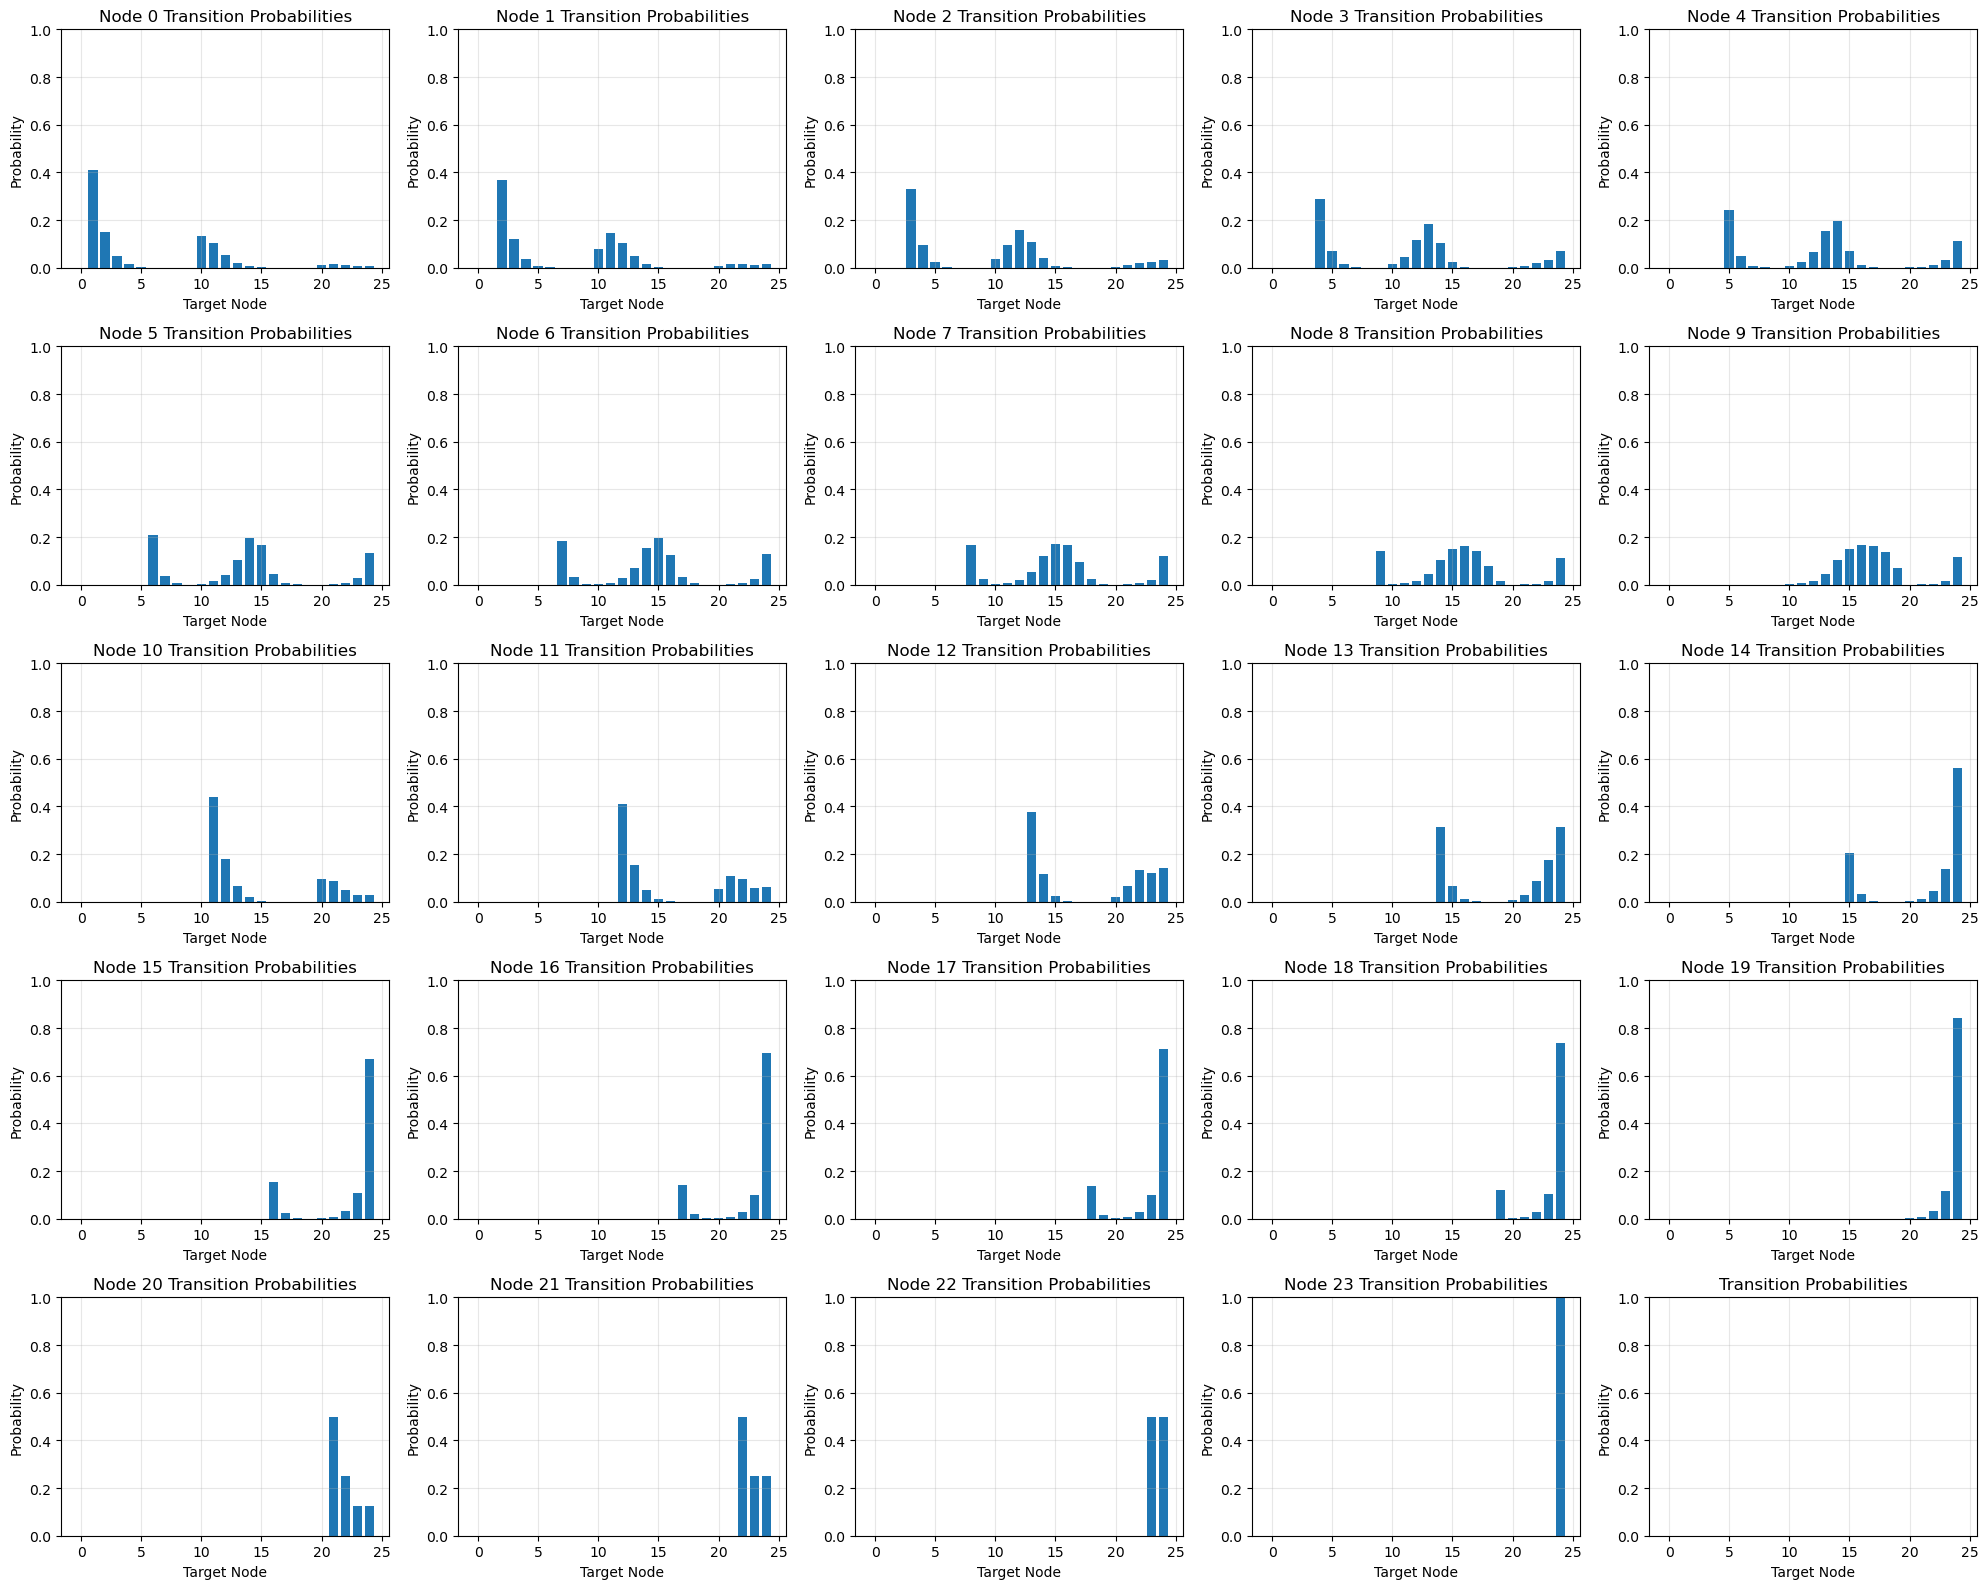

In [25]:
# Create a figure with 25 subplots (5x5 grid) to visualize transition probabilities
# for nodes 0 to 24
print('There probabilities always sum to 1 for each source node!')
fig, axes = plt.subplots(5, 5, figsize=(20, 16))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Get the dense array representation of Pe_csr
Pe_array = Pe_csr.toarray()

# For each node from 0 to 24, plot the outgoing transition probabilities
for i in range(25):
    ax = axes[i]
    
    # Extract outgoing transition probabilities for node i
    probs = Pe_array[i, :]
    
    # Only plot non-zero probabilities for clarity
    # non_zero_indices = np.where(probs > 0)[0]
    # non_zero_probs = probs[non_zero_indices]
    
    # # Create the bar chart
    # ax.bar(non_zero_indices, non_zero_probs)
    ax.bar(range(25), probs[:25])
    
    # Set title and labels
    ax.set_title(f'Node {i} Transition Probabilities')
    ax.set_xlabel('Target Node')
    ax.set_ylabel('Probability')
    
    # Set y-axis limit to [0, 1] since these are probabilities
    ax.set_ylim(0, 1)
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3)

plt.title('Transition Probabilities')
plt.tight_layout()
plt.show()


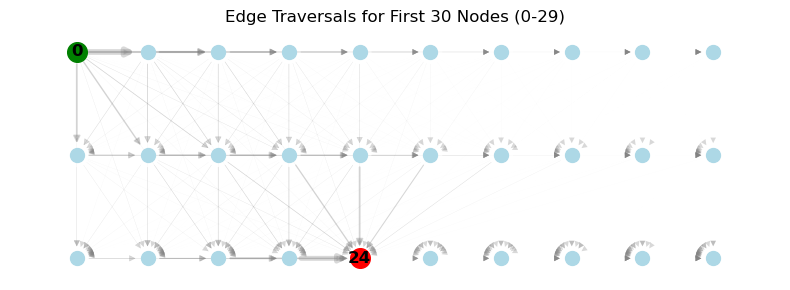

In [26]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Extract the edge traversals data
edge_traversals_array = edge_traversals.toarray()

# Create a new graph for visualization
G_vis = nx.DiGraph()

# Add only the first 30 nodes with positions based on grid layout
for i in range(30):
    row, col = i // 10, i % 10
    G_vis.add_node(str(i), pos=(col, 9-row))  # Adjust row to flip y-axis for better visualization

# Add edges with weights from edge_traversals (only for the first 30 nodes)
for i in range(30):
    for j in range(30):
        if edge_traversals_array[i, j] > 0:
            G_vis.add_edge(str(i), str(j), weight=edge_traversals_array[i, j])

# Get positions for all nodes
pos = nx.get_node_attributes(G_vis, 'pos')

# Create figure
plt.figure(figsize=(8, 3))

# Extract the path from node 0 to node 24
path_edges = []
current_node = '0'
target_node = '24'

# Find path with highest traversal weights
while current_node != target_node:
    neighbors = list(G_vis.neighbors(current_node))
    if not neighbors:
        break
    
    # Find neighbor with highest traversal weight
    next_node = max(neighbors, key=lambda n: G_vis[current_node][n]['weight'])
    path_edges.append((current_node, next_node))
    current_node = next_node

# Draw all nodes
nx.draw_networkx_nodes(G_vis, pos, node_size=100, node_color='lightblue')

# Draw all edges with varying width based on traversal weight
edges = G_vis.edges()
weights = [G_vis[u][v]['weight'] * 10 for u, v in edges]  # Scale for better visualization
nx.draw_networkx_edges(G_vis, pos, edgelist=edges, width=weights, alpha=0.3, edge_color='gray')

# Highlight start and end nodes
nx.draw_networkx_nodes(G_vis, pos, nodelist=['0'], node_size=200, node_color='green')
nx.draw_networkx_nodes(G_vis, pos, nodelist=['24'], node_size=200, node_color='red')

# Add labels for start and end nodes
nx.draw_networkx_labels(G_vis, pos, labels={'0': '0', '24': '24'}, font_weight='bold')

plt.title('Edge Traversals for First 30 Nodes (0-29)')
plt.axis('off')
plt.tight_layout()
plt.show()


# <font color='green'>Boltzmann Sampling</font>

Converged after 52 iterations.
Empirical Z:  [1.55896664 1.73642424 1.7331206  1.5583131  1.22517265 0.80942624
 0.45499952 0.22697304 0.10201825 0.03893681 0.56784116 0.67838474
 0.7536052  0.77088245 0.65509633 0.36381508 0.15362789 0.05957014
 0.02194002 0.00725195 0.14652511 0.19914827 0.27067057 0.36787944
 1.        ]
Model Z:  [1.55896746 1.73642511 1.73312141 1.55831379 1.22517321 0.80942668
 0.45499985 0.22697326 0.10201839 0.03893687 0.56784153 0.67838512
 0.75360554 0.77088274 0.65509656 0.36381527 0.15362805 0.05957025
 0.02194008 0.00725198 0.14652528 0.19914845 0.27067072 0.36787956
 1.        ]


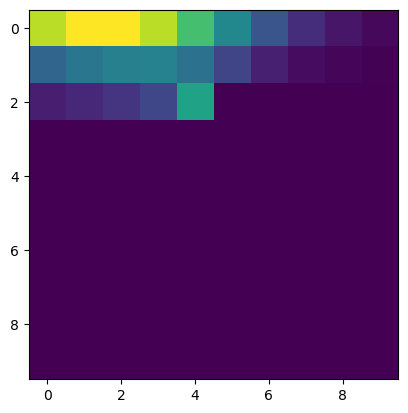

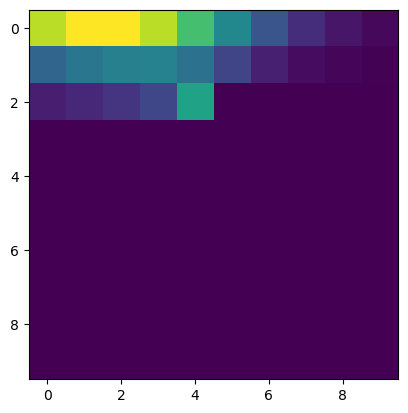

In [27]:
from boltzmann import compute_boltzmann_partition_functions, sample_boltzmann_path
# Create a sample graph
# G = nx.DiGraph()
# G.add_edge('S', 'A', cost=1.0)
# G.add_edge('S', 'B', cost=4.0)
# G.add_edge('A', 'C', cost=1.0)
# G.add_edge('A', 'D', cost=1.0)
# G.add_edge('B', 'D', cost=1.0)
# G.add_edge('C', 'G', cost=1.0)
# G.add_edge('D', 'G', cost=5.0)
# # Add a cycle and alternative path
# G.add_edge('D', 'A', cost=0.5) # Cycle A->D->A
# G.add_edge('B', 'G', cost=1.0) # Faster path from B

start = '0'
goal = '24'
paths = []

# 1. Compute Z values
z_vals = compute_boltzmann_partition_functions(G, goal, max_iterations=200)
# print("Computed Z values:", z_vals)
print("Empirical Z: ", np.array(list(z_vals.values()))[:25])
print("Model Z: ", np.exp(-V_bw[:25]))
plt.imshow(np.exp(-V_bw).reshape(10, 10))
plt.figure()
plt.imshow(np.array(list(z_vals.values())).reshape(10, 10))

In [28]:
from tqdm import tqdm

# Check if start node has non-zero Z value
if z_vals.get(start, 0) == 0:
    print(f"Goal {goal} is not reachable from Start {start}")
else:
    # 2. Sample paths
    for i in tqdm(range(9_000), desc="Sampling paths"):
        path = sample_boltzmann_path(G, start, goal, z_vals)
        if path:
            cost = sum(G.edges[u, v]['weight'] for u, v in zip(path[:-1], path[1:]))
            # print(f"Sample {i+1}: Path={path}, Cost={cost:.2f}, Exp(-Cost)={math.exp(-cost):.4f}")
            paths.append(path)
        else:
            print(f"Sample {i+1}: Failed to generate path.")

Sampling paths: 100%|██████████| 9000/9000 [00:00<00:00, 11586.86it/s]


In [29]:
from collections import Counter

def count_link_probabilities(paths):
    # Extract edges from all paths and count occurrences
    edge_counter = Counter()
    
    for path in paths:
        # Create pairs of consecutive nodes (edges)
        edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
        # Use a set to ensure each edge is counted only once per path
        unique_edges = set(edges)
        for edge in unique_edges:
            edge_counter[edge] += 1
    
    return dict(edge_counter)

empirical_link_counts = count_link_probabilities(paths)
empirical_number_of_paths = len(paths)

# Print the top 10 edges by probability
sorted_edges = sorted(empirical_link_counts.items(), key=lambda x: x[1], reverse=True)[:10]
print("\033[92mMarginal probabilities of links (i, j) in the sampled paths\033[0m")
for edge, count in sorted_edges:
    print(f"{edge}: {count}")
print(f'Number of paths: {empirical_number_of_paths}')


Marginal probabilities of links (i, j) in the sampled paths
('0', '1'): 3639
('23', '24'): 3242
('0', '2'): 1388
('1', '2'): 1301
('14', '24'): 1232
('0', '10'): 1196
('22', '24'): 1107
('12', '13'): 1093
('11', '12'): 1067
('22', '23'): 1043
Number of paths: 9000


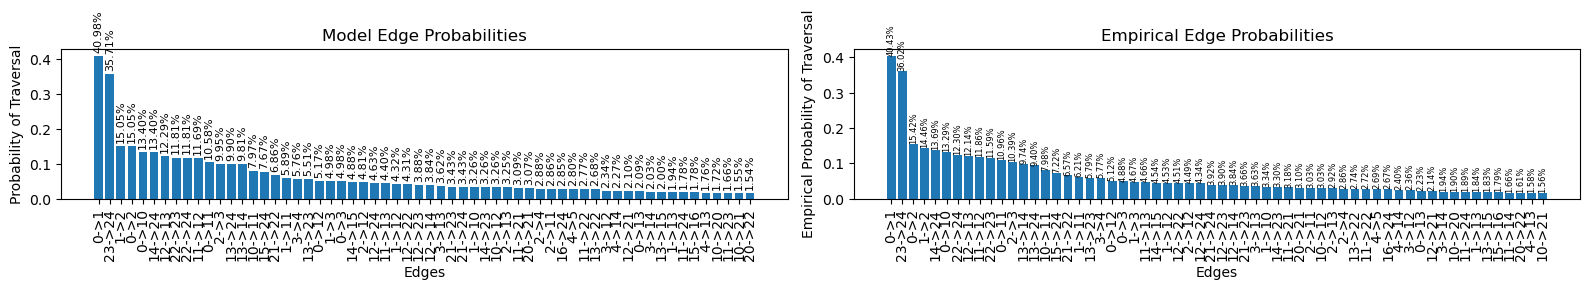

In [30]:
# Convert the Pe matrix to a list of (from_node, to_node, probability) tuples
# ================================ EXPECTED EDGE TRAVERSALS ================================
edge_probs = []
for i in range(edge_traversals_array.shape[0]):  # from node (row)
    for j in range(edge_traversals_array.shape[1]):  # to node (column)
        if edge_traversals_array[i, j] > 0:  # Only include edges with non-zero probability
            edge_probs.append((i, j, edge_traversals_array[i, j]))

# Sort by probability in descending order
sorted_edges = sorted(edge_probs, key=lambda x: x[2], reverse=True)

# Create a histogram of edge probabilities
plt.figure(figsize=(16, 3))
# 
plt.subplot(1, 2, 1)
# Extract edge labels and probabilities
edge_labels = [f"{edge[0]}->{edge[1]}" for edge in sorted_edges]
probabilities = [prob for _, _, prob in sorted_edges]
edge_labels = edge_labels[:60]
probabilities = probabilities[:60]

# Plot the histogram
plt.bar(range(len(probabilities)), probabilities)
plt.xlabel('Edges')
plt.ylabel('Probability of Traversal')
plt.title('Model Edge Probabilities')
plt.xticks(range(len(probabilities)), edge_labels, rotation=90)
plt.tight_layout()

# Add probability values on top of each bar
for i, prob in enumerate(probabilities):
    plt.text(i, prob + 0.01, f"{prob:.2%}", ha='center', fontsize=8, rotation=90, va='bottom')

# ================================ EMPIRICAL EDGE TRAVERSALS ================================
plt.subplot(1, 2, 2)

# Convert empirical_link_counts to a list of tuples (edge, count)
empirical_edges = [(edge, count) for edge, count in empirical_link_counts.items()]

# Sort by count in descending order
sorted_empirical_edges = sorted(empirical_edges, key=lambda x: x[1], reverse=True)

# Extract edge labels and counts
empirical_edge_labels = [f"{edge[0]}->{edge[1]}" for edge, _ in sorted_empirical_edges]
empirical_counts = [count for _, count in sorted_empirical_edges]

# Calculate probabilities (normalize counts)
empirical_probabilities = [count / empirical_number_of_paths for count in empirical_counts]
empirical_probabilities = empirical_probabilities[:60]
empirical_edge_labels = empirical_edge_labels[:60]

# Plot the histogram
plt.bar(range(len(empirical_probabilities)), empirical_probabilities)
plt.xlabel('Edges')
plt.ylabel('Empirical Probability of Traversal')
plt.title('Empirical Edge Probabilities')
plt.xticks(range(len(empirical_probabilities)), empirical_edge_labels, rotation=90)

# Add probability values on top of each bar
for i, prob in enumerate(empirical_probabilities):
    plt.text(i, prob + 0.001, f"{prob:.2%}", ha='center', fontsize=6, rotation=90, va='bottom')

plt.tight_layout()

plt.show()

In [31]:
# Compare empirical edge probabilities with model predictions
print("Comparing empirical edge probabilities with model predictions:")
print("=" * 80)
print(f"{'Edge':<15} {'Empirical':<15} {'Model':<15} {'Difference':<15}")
print("-" * 80)

# For each of the top 60 empirical edges, find the corresponding model probability
for i, edge_label in enumerate(empirical_edge_labels):
    # Parse the edge from the label (format: "source->target")
    source, target = map(int, edge_label.split('->'))
    edge = (source, target)
    
    # Get the empirical probability
    empirical_prob = empirical_probabilities[i]
    
    # Get the model probability (default to 0 if not found)
    model_prob = edge_traversals_array[edge]
    
    # Calculate the difference
    difference = empirical_prob - model_prob
    
    # Print the comparison
    print(f"{edge_label:<15} {empirical_prob:.6f}    {model_prob:.6f}    {difference:.6f}")

print("=" * 80)


Comparing empirical edge probabilities with model predictions:
Edge            Empirical       Model           Difference     
--------------------------------------------------------------------------------
0->1            0.404333    0.409755    -0.005422
23->24          0.360222    0.357090    0.003133
0->2            0.154222    0.150454    0.003768
1->2            0.144556    0.150454    -0.005898
14->24          0.136889    0.133997    0.002892
0->10           0.132889    0.133997    -0.001108
22->24          0.123000    0.118058    0.004942
12->13          0.121444    0.122882    -0.001437
11->12          0.118556    0.116897    0.001659
22->23          0.115889    0.118058    -0.002170
0->11           0.109556    0.105792    0.003763
2->3            0.103889    0.099532    0.004357
13->14          0.097444    0.098125    -0.000681
13->24          0.094000    0.098988    -0.004988
10->11          0.079778    0.079714    0.000064
15->24          0.072222    0.076689    -0.004467


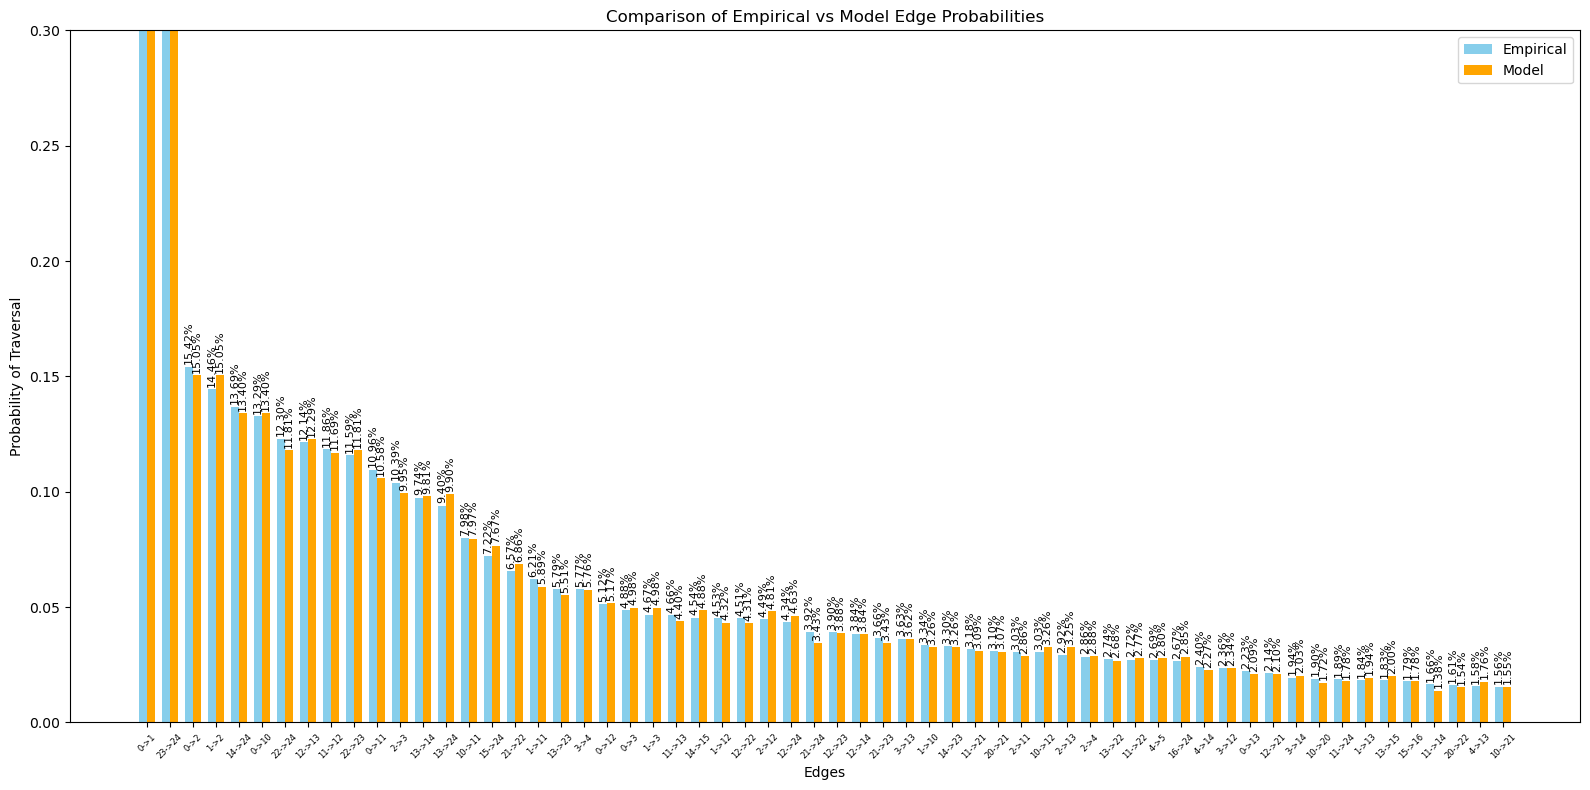

In [32]:
# Create a figure for comparing empirical vs model probabilities
plt.figure(figsize=(16, 8))

# Prepare data for side-by-side bars
x = np.arange(len(empirical_edge_labels))
width = 0.35  # width of the bars

# Extract model probabilities for the same edges
model_probabilities = []
for edge_label in empirical_edge_labels:
    source, target = map(int, edge_label.split('->'))
    edge = (source, target)
    model_prob = edge_traversals_array[edge]
    model_probabilities.append(model_prob)

# Plot bars
plt.bar(x - width/2, empirical_probabilities, width, label='Empirical', color='skyblue')
plt.bar(x + width/2, model_probabilities, width, label='Model', color='orange')

# Add labels and title
plt.xlabel('Edges')
plt.ylabel('Probability of Traversal')
plt.title('Comparison of Empirical vs Model Edge Probabilities')
plt.xticks(x, empirical_edge_labels, rotation=45, fontsize=6)

# Add a legend
plt.legend()

# Add probability values on top of each bar (empirical)
for i, prob in enumerate(empirical_probabilities):
    if prob < 0.3:
        plt.text(i - width/2, prob + 0.001, f"{prob:.2%}", ha='center', fontsize=8, rotation=90, va='bottom')

# Add probability values on top of each bar (model)
for i, prob in enumerate(model_probabilities):
    if prob < 0.3:
        plt.text(i + width/2, prob + 0.001, f"{prob:.2%}", ha='center', fontsize=8, rotation=90, va='bottom')

plt.ylim(0, 0.3)

plt.tight_layout()
plt.show()


# KL Divergence

$$ D_{KL} (p || q) = \sum_{e} p(e) \frac{\log{p(e)}}{\log{q(e)}} $$

In [33]:
# Calculate KL divergence between empirical and model probabilities
def kl_divergence(p, q):
    """
    Calculate the Kullback-Leibler divergence between two probability distributions.
    
    Parameters:
    p (array-like): First probability distribution
    q (array-like): Second probability distribution
    
    Returns:
    float: KL divergence KL(p||q)
    """
    # Add small epsilon to avoid division by zero or log(0)
    epsilon = 1e-10
    
    # Ensure both distributions are valid probability distributions
    p = np.array(p) + epsilon
    q = np.array(q) + epsilon
    
    # Normalize if needed
    p = p / np.sum(p)
    q = q / np.sum(q)
    
    # Calculate KL divergence: KL(p||q) = sum(p * log(p/q))
    kl_div = np.sum(p * np.log(p / q))
    
    return kl_div

# Calculate KL divergence between empirical and model probabilities
kl_empirical_to_model = kl_divergence(empirical_probabilities, model_probabilities)
kl_model_to_empirical = kl_divergence(model_probabilities, empirical_probabilities)

print(f"KL Divergence (Empirical || Model): {kl_empirical_to_model:.6f}")
print(f"KL Divergence (Model || Empirical): {kl_model_to_empirical:.6f}")


KL Divergence (Empirical || Model): 0.000829
KL Divergence (Model || Empirical): 0.000825


# <font color='green'>Preference Learning with Gradient Descent</font>

## Whole Graph Gradient Descent

We have several variations that we can use. At this point, it is **unclear** which method is the most stable:
- Vanilla gradient descent (accumulated gradient descent through a Bellman-like process).
- Approximated gradient descent that matches occurences between model and empirical traversal counts.
- KL divergence minimization (this heavily sanctions the tails).

(2) appears to be the most transparent to implement. (3) could put too much weights on the tails, while ignoring the more frequently traversed edges. (1) sounds cool in a paper.

<font color="green">Okay I decide to go with (2) first. If it works, then we can try (1). Surely (1) is better for a more complicated cost function.</font>

The update formula for the preference term of each edge is:
$$ \theta_{e} = \theta_{e} - \texttt{LR} \nabla_{\theta_e} \ell(\theta) $$

and in the case of $$c(e) = \texttt{distance}_e + \alpha \theta_e$$

the expression simplifies to:
$$ \theta_{e} = \theta_{e} - \texttt{LR} \alpha (\tilde{N}_e - N_e)$$ 

where $\tilde{N}_e$ is the empirical traversals of edge $e$ and $N_e$ is the expected number of traversals on edge $e$. To further simplify the expression, we also group $\texttt{LR} \alpha$ together into a single term $\alpha$.

## Cost Structure

In [34]:
# Intrinsic Costs
intrinsic_costs_dict = compute_edge_costs_dict(G, alpha_pref = 0) # 0 means no preference, just distance only!
A, C, idx2node = graph_to_sparse_matrices(G, intrinsic_costs_dict)

<font color="red">We will skip the shared parameters for now.</font>

## Preparing the demonstration dataset

In [35]:
import random

def sample_routes(routes, probabilities, num_samples=1):
    """
    Sample routes based on their probabilities.
    
    Args:
        routes: List of routes, where each route is a list of locations.
        probabilities: List of probabilities corresponding to each route.
        num_samples: Number of routes to sample.
        
    Returns:
        List of sampled routes.
    """
    if len(routes) != len(probabilities):
        raise ValueError("Number of routes must match number of probabilities")
    
    if abs(sum(probabilities) - 1.0) > 1e-10:
        raise ValueError("Probabilities must sum to 1")
    
    return random.choices(routes, weights=probabilities, k=num_samples)

# Sample 1000 routes for demonstration dataset
demonstration_set = sample_routes(routes_0_24_final, routes_0_24_final_prob, num_samples=1000)

# Convert to a list of numbers
demonstration_set_int = list()
for route in demonstration_set:
    int_route = [int(node_id) for node_id in route]
    demonstration_set_int.append(int_route)

## Performing Gradient Descent

In [36]:
for route in demonstration_set:
    demonstration_set_int.append([int(node_id) for node_id in route])

In [37]:
from bellman_ford_sparse1110 import fit 

# Edge-Specific Costs (because we modify the edge_pref_matrix in place)
from scipy import sparse
# Create a zero sparse matrix with the same sparsity pattern as A
edge_pref_matrix = sparse.csr_matrix((np.zeros_like(A.data), A.indices.copy(), A.indptr.copy()), shape=A.shape, dtype=float)
edge_properties = {'preference': (edge_pref_matrix, 1.0)}

# If we have the shared costs, we should update them here as well (since they will be modified in place too)

new_edge_specific_costs, new_shared_costs = fit(A, demonstrations=demonstration_set_int, 
                                                intrinsic_costs=C,
                                                edge_specific_costs=edge_properties,
                                                shared_costs=None,
                                                source_node=0,
                                                goal_node=24,
                                                learning_rate=0.1)



Iteration 0: Gradient norm = 0.357090
Iteration 1: Gradient norm = 0.347374
Iteration 2: Gradient norm = 0.338062
Iteration 3: Gradient norm = 0.329135
Iteration 4: Gradient norm = 0.320577
Iteration 5: Gradient norm = 0.312371
Iteration 6: Gradient norm = 0.304500
Iteration 7: Gradient norm = 0.296949
Iteration 8: Gradient norm = 0.289702
Iteration 9: Gradient norm = 0.282744
Iteration 10: Gradient norm = 0.276062
Iteration 11: Gradient norm = 0.269642
Iteration 12: Gradient norm = 0.263472
Iteration 13: Gradient norm = 0.257539
Iteration 14: Gradient norm = 0.251831
Iteration 15: Gradient norm = 0.246339
Iteration 16: Gradient norm = 0.241050
Iteration 17: Gradient norm = 0.235956
Iteration 18: Gradient norm = 0.231047
Iteration 19: Gradient norm = 0.226315
Iteration 20: Gradient norm = 0.221750
Iteration 21: Gradient norm = 0.217345
Iteration 22: Gradient norm = 0.213093
Iteration 23: Gradient norm = 0.208986
Iteration 24: Gradient norm = 0.205018
Iteration 25: Gradient norm = 0.201

## Resample from the new cost function

In [63]:
# Calculate the partition function for the new cost function
from bellman_ford_sparse1110 import get_cost_matrix
costs_new = get_cost_matrix(A, C, new_edge_specific_costs, shared_properties=None)
V_bw_new = bellman_bw(A, costs_new, goal_node=24)
Z_bw_new = np.exp(-V_bw_new)

# Convert Z_bw_new to a dictionary
Z_bw_new_dict = {str(node): Z_bw_new[node] for node in idx2node}


In [64]:
# Create a new graph with the new costs
import networkx as nx
from boltzmann import sample_boltzmann_path
import math

# Create a new directed graph
GX = nx.DiGraph()

# Add nodes to the graph
for node in idx2node:
    GX.add_node(node)

# Add edges with the new costs
paths = []  # Initialize paths list for later use

# Iterate through the sparse matrix to add edges with costs
for i, j in zip(*costs_new.nonzero()):
    # Convert integer indices to node IDs (strings)
    source = idx2node[i]
    target = idx2node[j]
    
    # Get the cost from the sparse matrix
    cost = costs_new[i, j]
    
    # Add the edge with the cost as weight
    GX.add_edge(source, target, weight=cost)


In [69]:
from tqdm import tqdm

# Check if start node has non-zero Z value
if Z_bw_new_dict.get('0', 0) == 0:
    print(f"Goal {goal} is not reachable from Start {start}")
else:
    # 2. Sample paths
    for i in tqdm(range(9_000), desc="Sampling paths"):
        path = sample_boltzmann_path(GX, '0', '24', Z_bw_new_dict)
        if path:
            # cost = sum(G.edges[u, v]['weight'] for u, v in zip(path[:-1], path[1:]))
            # print(f"Sample {i+1}: Path={path}, Cost={cost:.2f}, Exp(-Cost)={math.exp(-cost):.4f}")
            paths.append(path)
        else:
            print(f"Sample {i+1}: Failed to generate path.")

Sampling paths: 100%|██████████| 9000/9000 [00:00<00:00, 10100.17it/s]


In [81]:
# Count occurrences of each unique path
from collections import Counter

# Convert each path to a tuple so it can be used as a dictionary key
path_tuples = [tuple(path) for path in paths]
path_counts = Counter(path_tuples)
total_paths = len(paths)

# Calculate probability for each unique path
path_probabilities = {}
for path_tuple, count in path_counts.items():
    probability = count / total_paths
    path_probabilities[path_tuple] = probability

# Sort by probability (descending)
sorted_paths = sorted(path_probabilities.items(), key=lambda x: x[1], reverse=True)

# Create two separate lists: routes and their probabilities
routes = [list(path_tuple) for path_tuple, _ in sorted_paths]
probabilities = [prob for _, prob in sorted_paths]

print(f"Found {len(routes)} unique routes")
print(f"Top 10 routes by probability:")
for i in range(min(10, len(routes))):
    if routes[i] in routes_0_24_final:
        print(f"Route: {routes[i]}, Sampled Probability: {probabilities[i]:.4f}, Demonstrated Probability: {routes_0_24_final_prob[routes_0_24_final.index(routes[i])]}")
    else:
        print(f"Route: {routes[i]}, Sampled Probability: {probabilities[i]:.4f}")



Found 164 unique routes
Top 10 routes by probability:
Route: ['0', '1', '24'], Sampled Probability: 0.1721, Demonstrated Probability: 0.16225904321602524
Route: ['0', '13', '24'], Sampled Probability: 0.1509, Demonstrated Probability: 0.17154088428738715
Route: ['0', '12', '24'], Sampled Probability: 0.1460, Demonstrated Probability: 0.16433663431663106
Route: ['0', '22', '24'], Sampled Probability: 0.1423, Demonstrated Probability: 0.13935537467023043
Route: ['0', '2', '14', '24'], Sampled Probability: 0.1368, Demonstrated Probability: 0.1513019480119687
Route: ['0', '24'], Sampled Probability: 0.0941, Demonstrated Probability: 0.09460511695306807
Route: ['0', '6', '15', '24'], Sampled Probability: 0.0618, Demonstrated Probability: 0.06291783474983088
Route: ['0', '8', '24'], Sampled Probability: 0.0402, Demonstrated Probability: 0.053683163794858636
Route: ['0', '12', '13', '24'], Sampled Probability: 0.0030
Route: ['0', '13', '14', '24'], Sampled Probability: 0.0022


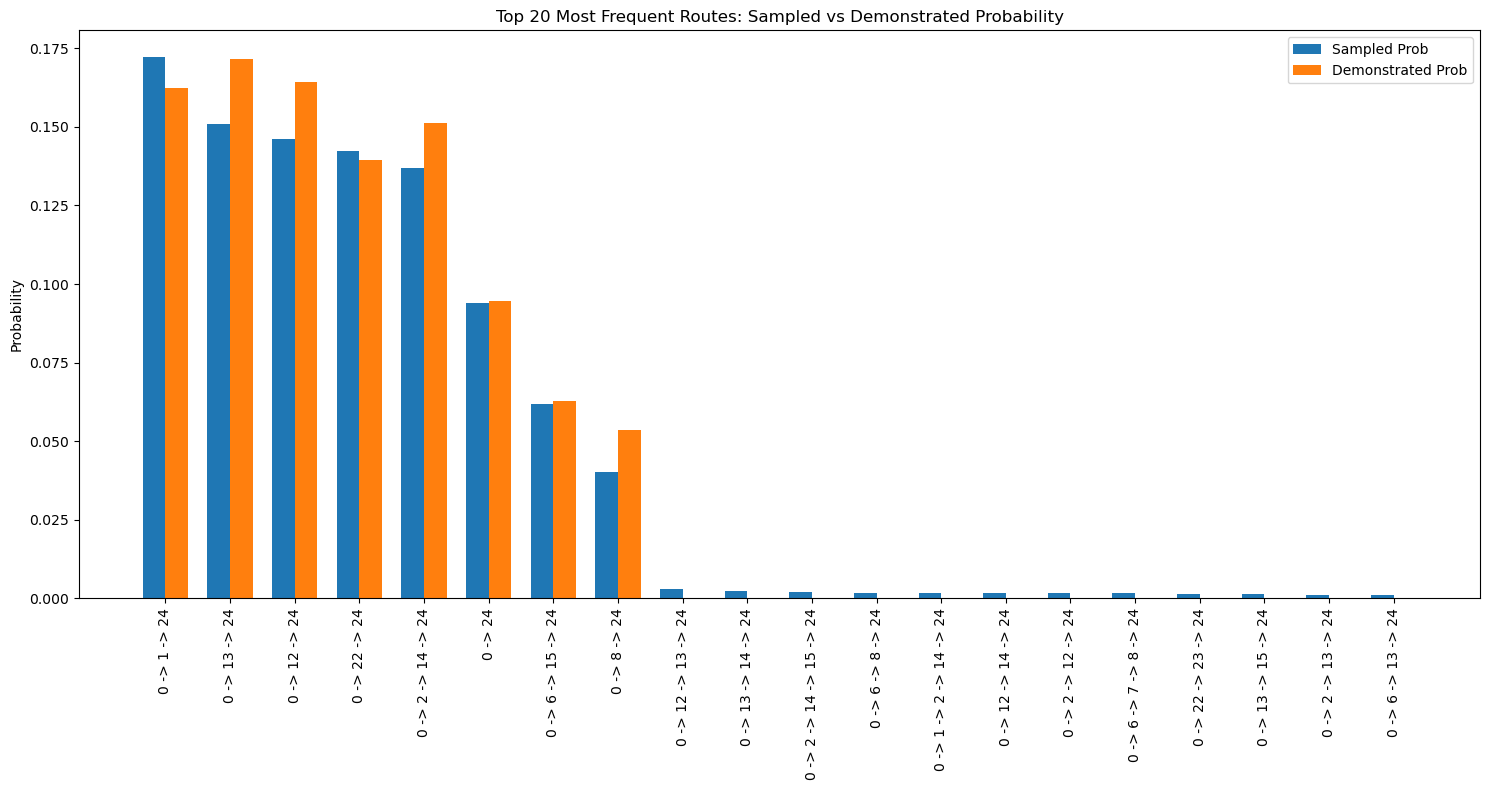

In [83]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# --- Assuming these variables are pre-defined ---
# routes = [['0', '1', '24'], ['0', '13', '24'], ...] # Your list of sampled routes
# probabilities = [0.1, 0.05, ...] # Corresponding sampled probabilities
# routes_0_24_final = [['0', '1', '24'], ['0', '2', '14', '24'], ...] # Unique demonstrated routes
# routes_0_24_final_prob = [0.15, 0.08, ...] # Corresponding demonstrated probabilities
# --- End of assumed variables ---

# Convert routes to tuples for counting (lists are not hashable)
route_tuples = [tuple(route) for route in routes]

# Count the frequency of each route
route_counts = Counter(route_tuples)

# Get the 20 most common routes (tuples) and their counts
most_common_routes_tuples = [route for route, count in route_counts.most_common(20)]

# Prepare data for plotting
route_labels = []
sampled_probs = []
demonstrated_probs = []

# Find the probabilities for the most common routes
for route_tuple in most_common_routes_tuples:
    route_list = list(route_tuple)
    route_str = ' -> '.join(route_list)
    route_labels.append(route_str)

    # Find the first occurrence index in the original routes list for sampled probability
    try:
        first_occurrence_index = routes.index(route_list)
        sampled_probs.append(probabilities[first_occurrence_index])
    except ValueError:
        # Should not happen if route_tuple came from routes, but good practice
        sampled_probs.append(0) # Or handle as appropriate

    # Find the index in the demonstrated routes list
    try:
        demonstrated_index = routes_0_24_final.index(route_list)
        demonstrated_probs.append(routes_0_24_final_prob[demonstrated_index])
    except ValueError:
        # Handle case where a frequent sampled route is not in the demonstrated list
        print(f"Warning: Route {route_str} not found in demonstrated routes. Setting demonstrated probability to 0.")
        demonstrated_probs.append(0) # Append 0 or np.nan, or skip the route

# --- Plotting ---
x = np.arange(len(route_labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 8)) # Increase figure size for readability
rects1 = ax.bar(x - width/2, sampled_probs, width, label='Sampled Prob')
rects2 = ax.bar(x + width/2, demonstrated_probs, width, label='Demonstrated Prob')

# Add some text for labels, title and axes ticks
ax.set_ylabel('Probability')
ax.set_title('Top 20 Most Frequent Routes: Sampled vs Demonstrated Probability')
ax.set_xticks(x)
ax.set_xticklabels(route_labels, rotation=90) # Rotate labels for better visibility
ax.legend()

# Optional: Add value labels on top of bars
# ax.bar_label(rects1, padding=3, fmt='%.3f', rotation=90, size=8)
# ax.bar_label(rects2, padding=3, fmt='%.3f', rotation=90, size=8)

fig.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()